# Task
Using the rugarch package, find the best ARIMA-GARCH model with normal and 
student's t errors to forecast the 1-day ahead VaR and Expected Shortfall (ES) 
using a 250-day rolling window for the companies from the 1st HW. 
Backtest the estimated VaR and ES

# Value-at-Risk 
VaR на уровне 5% – это квантиль на уровне 5%. То есть это такой уровень доходности, что в 95% случаев доходность будут лучше. 

In [1]:
get_var <- function(vec, percent=0.05) { # returns Value at risk
    quantile(ret_db, percent)
}

# Expected shortfill
ES, conditional value at risk (CVaR), average value at risk (AVaR), и expected tail loss (ETL). Но мы будем говорить ES. ES - Это среднее значение по всем тем точкам, что оказались левее VaR, То есть среднее по худшим 5%

In [27]:
get_es <- function(vec, percent=0.05) {
    mean(vec[vec <= quantile(vec, percent)])
}

In [28]:
library(rugarch)
library(fGarch)
install.packages("rmarkdown")

Installing package into ‘/home/alex/R/x86_64-conda_cos6-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)


Date,Open,High,Low,Close,Adj.Close,Volume
2015-12-31,"14,14","14,16","14,04","14,09","10,898071",19881000
2016-01-04,"13,87","14,00","13,75","13,97","10,805258",38618500
2016-01-05,"13,97","14,00","13,51","13,72","10,611893",50267500
2016-01-06,"13,56","13,56","13,05","13,11","10,140079",61285500
2016-01-07,"12,90","13,04","12,60","12,70","9,822961",57846700
2016-01-08,"13,05","13,10","12,50","12,54","9,699207",46199400


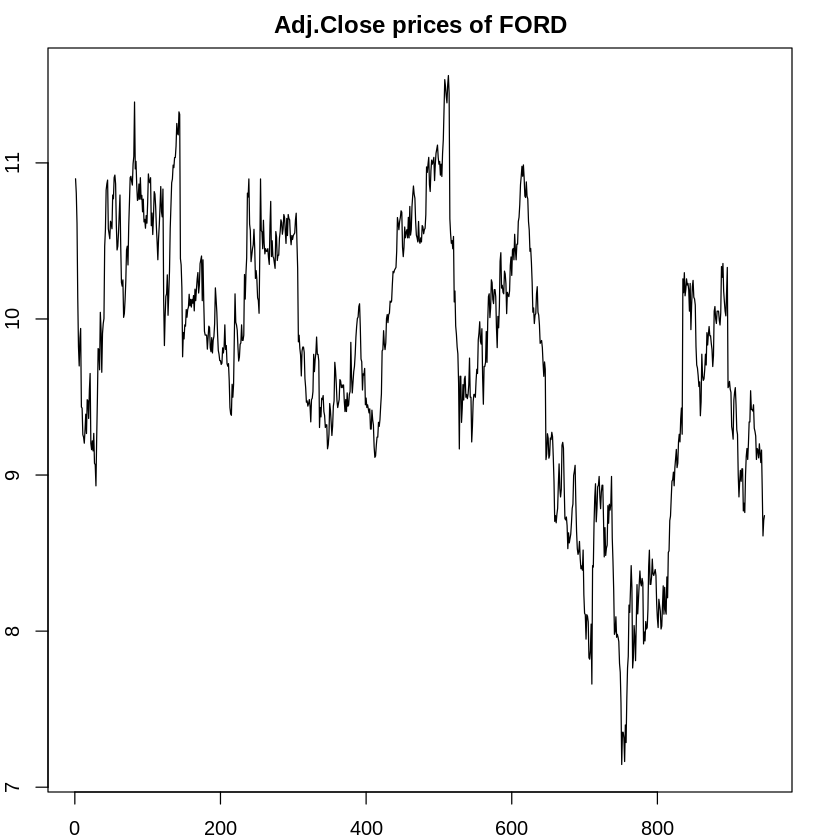

In [29]:
# Calculate Expected shortfill
get_es <- function(vec, percent=0.05) { 
  mean(vec[vec <= quantile(vec, percent)])
}


##############################################
####### Read data and fetch @prices
##############################################
data <- read.csv("/home/alex/Education/6/CMF/time_series/4/data/Ford.csv", header=TRUE, sep=",")
head(data)
prices_db = data[,'Adj.Close']
par(mar = rep(2, 4)) # to solve error: "Error in plot.new() : figure margins too large"
plot(prices_db, type="l", main="Adj.Close prices of FORD")

[1] -0,008516461 -0,017895454 -0,044460870 -0,031273721 -0,012598442

[1] 473
[1] 474


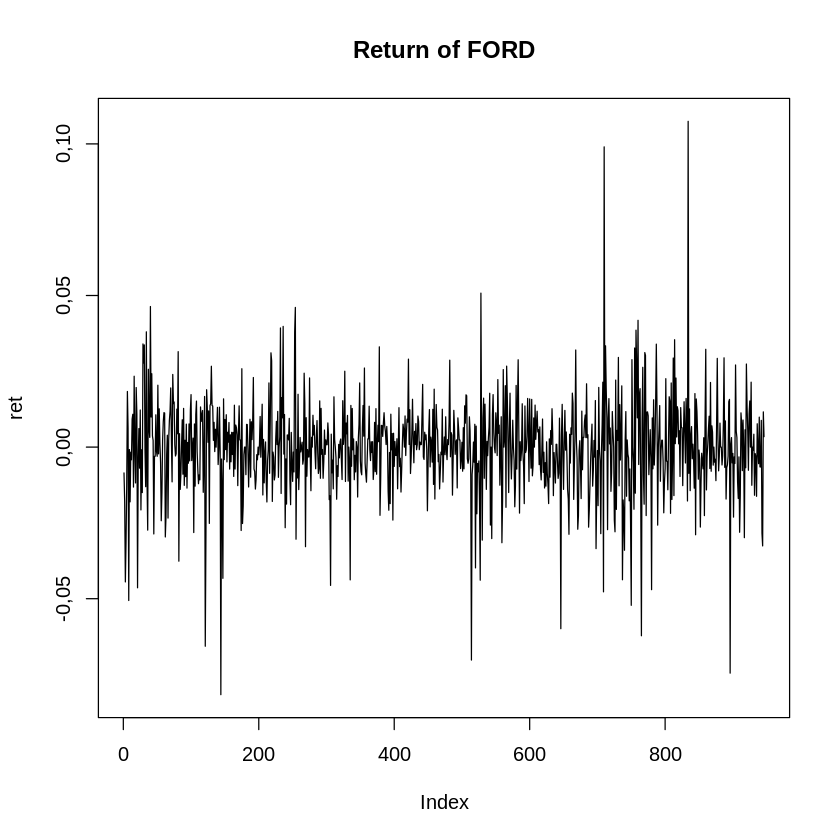

[1] 35

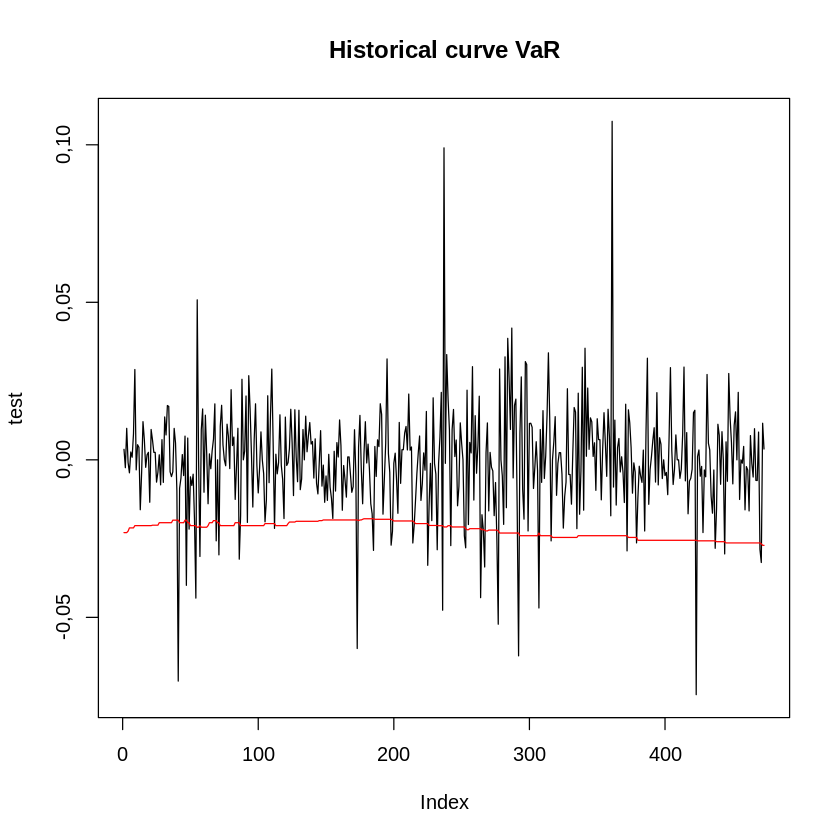

In [31]:
##############################################
####### Calculate return @ret
##############################################
T = length(prices_db) - 1

ret <- (prices_db[2:(T+1)] / prices_db[1:T]) - 1 # vector of returns
head(ret, 5)
plot(ret, type="l", main="Return of FORD")


##############################################
####### Split @ret on  @train and @test
##############################################
train <- ret[1:(length(ret) %/% 2)]
test  <- ret[(length(ret) %/% 2) :length(ret)]
print(length(train))
print(length(test))

##############################################
####### Calculate historical VaR
##############################################
N <- length(train) # Длина тренировочной выборки.
test <- ret[(N+1):length(ret)] # test sample
VaR <- rep(0, length(test)) # array of VaR values
for (i in (N+1):length(ret)) {
  train <- ret[(i-N):(i-1)]
  VaR[i-N] <- quantile(train, 0.05)
}
plot(test, type="l", main = "Historical curve VaR")
lines(VaR, col="red")

hit <- sum(test<VaR) # number of limit overcomes
hit


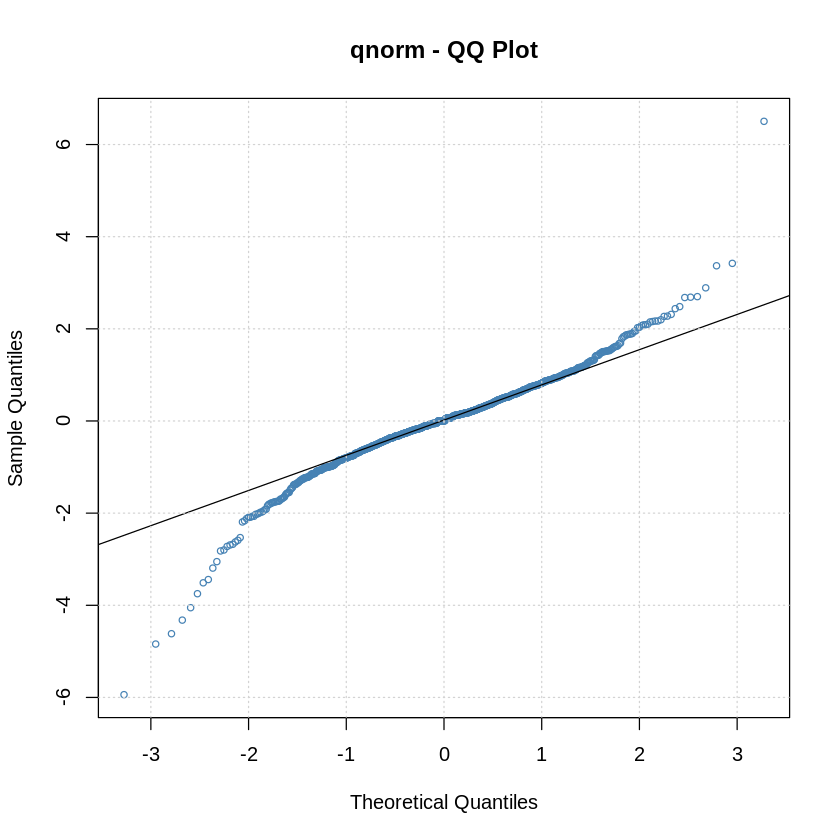

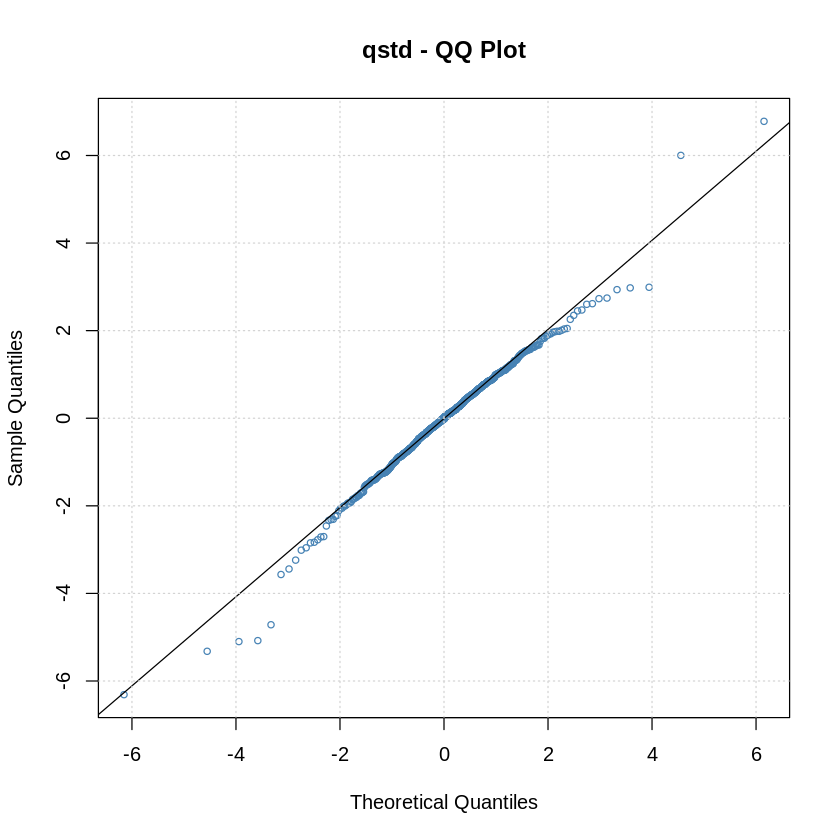

In [32]:
##############################################
####### Compare QQ Plot of Normal and Student distributions
##############################################
garch.norm <- garchFit(~1+garch(1,1),data=ret,trace=F)
plot(garch.norm, which=13)

garch.st <- garchFit(~1+garch(1,1),data=ret,trace=F, cond.dist="std")
plot(garch.st, which=13) 
# QQ Plot for Student is better


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0,000289    0,000392  0,73828 0,460344
ar1    -0,689670    0,346372 -1,99113 0,046467
ma1     0,663030    0,357525  1,85450 0,063668
omega   0,000002    0,000004  0,52317 0,600859
alpha1  0,023773    0,013181  1,80352 0,071307
beta1   0,967870    0,014630 66,15645 0,000000
shape   3,833852    0,430626  8,90297 0,000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0,000289    0,000394  0,733896 0,463012
ar1    -0,689670    0,297308 -2,319719 0,020356
ma1     0,663030    0,305944  2,167162 0,030222
omega   0,000002    0,000026  0,078128 0,937726
alpha1  0,023773    0,096006  0,247615 0,804433
bet

VaR Backtest Report
Model:				sGARCH-std
Backtest Length:	646
Data:				

alpha:				1%
Expected Exceed:	6,5
Actual VaR Exceed:	10
Actual %:			1,5%

Unconditional Coverage (Kupiec)
Null-Hypothesis:	Correct Exceedances
LR.uc Statistic:	1,679
LR.uc Critical:		3,841
LR.uc p-value:		0,195
Reject Null:		NO

Conditional Coverage (Christoffersen)
Null-Hypothesis:	Correct Exceedances and
					Independence of Failures
LR.cc Statistic:	1,994
LR.cc Critical:		5,991
LR.cc p-value:		0,369
Reject Null:		NO
[1] "ES"
[1] -0,06670404


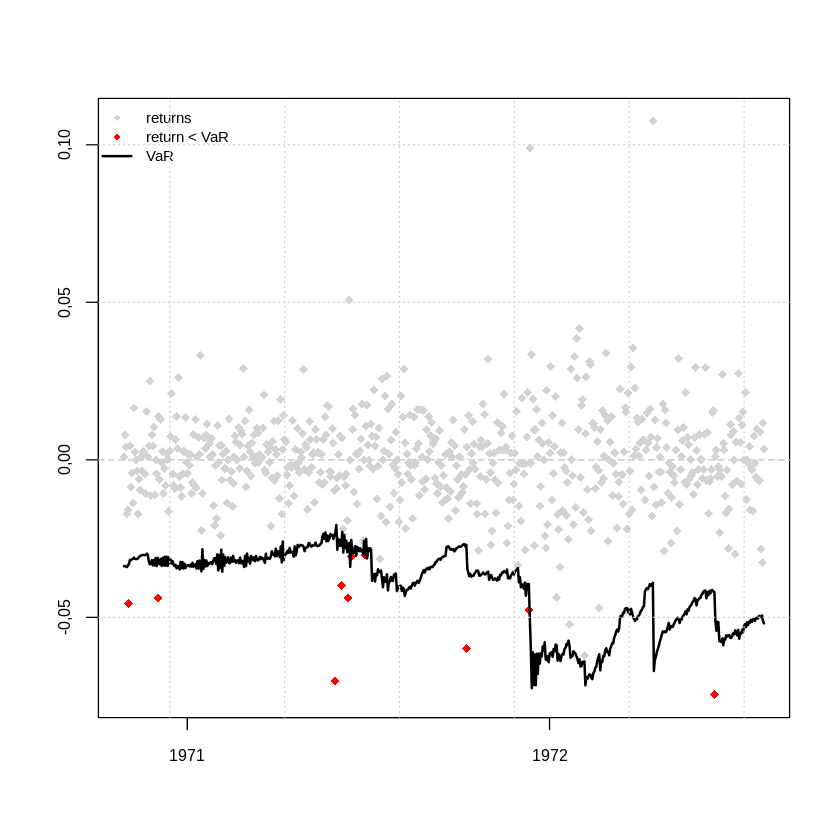

In [38]:
##############################################
####### Create ARIMA(1,0,1)-GARCH(1,1) model
####### n.ahead = 1, refit.every = 250
##############################################


model_F <- ugarchspec(variance.model = list(garchOrder = c(1,1)), mean.model = list(armaOrder = c(1,1), arfima=FALSE),distribution.model = "std")
model_F_fit <- ugarchfit(spec = model_F,data=ret)
model_F_fit

roll <- ugarchroll(model_F,ret,n.start = 300, refit.window = 'moving', moving.size = 250, calculate.VaR = TRUE, VaR.alpha = 0.01)
report(roll)
plot(roll, which=4) # "which=4" means print VaR
print("ES")
print(get_es(roll@forecast$VaR[,"alpha(1%)"]))

Date,Open,High,Low,Close,Adj.Close,Volume
2015-12-31,"3,65","3,74","3,65","3,67","2,524473",442300
2016-01-04,"3,66","3,68","3,60","3,65","2,510716",581600
2016-01-05,"3,67","3,71","3,66","3,70","2,545110",432200
2016-01-06,"3,59","3,63","3,57","3,58","2,462565",599800
2016-01-07,"3,44","3,50","3,40","3,43","2,359385",870200
2016-01-08,"3,46","3,47","3,36","3,39","2,331870",306400


[1] 2,524473 2,510716 2,545110 2,462565 2,359385 2,331870 2,318113 2,373142
  [9] 2,318113 2,331870 2,194297 2,166782 2,139267 2,104874 2,290598 2,228690
 [17] 2,297477 2,352506 2,441929 2,469444 2,352506 2,221812 2,373142 2,373142
 [25] 2,352506 2,304355 2,242448 2,283720 2,242448 2,269962 2,359385 2,483201
 [33] 2,421293 2,428171 2,510716 2,469444 2,476322 2,496958 2,469444 2,517595
 [41] 2,634532 2,620775 2,689561 2,772106 2,882164 2,751469 2,834013 2,778984
 [49] 2,806499 2,820256 2,717076 2,840892 2,937194 2,957830 2,999102 3,012859
 [57] 2,882164 2,889043 2,875285 2,889043 2,957830 2,964708 2,992223 2,875285
 [65] 2,834013 2,916558 2,861528 2,937194 2,992223 3,122918 3,136675 3,067888
 [73] 3,012859 2,992223 3,212341 3,377429 3,301764 3,274249 3,260491 3,384307
 [81] 3,384307 3,439337 3,570031 3,480609 3,425579 3,274249 3,294884 3,294884
 [89] 3,246734 3,260491 3,356793 3,356793 3,301764 3,315521 3,246734 3,143553
 [97] 3,040374 2,978466 2,964708 2,999102 3,047252 3,074767 3,074767 2,992223
[105] 2,923437 2,930315 2,964708 3,047252 3,102282 3,122918 3,061009 2,985344
[113] 2,957830 2,909679 2,923437 2,909679 2,957830 3,019737 3,054131 2,985344
[121] 3,081646 2,937194 2,875285 2,950951 2,992223 2,978466 2,999102 2,978466
[129] 2,971587 2,923437 2,978466 2,992223 3,026616 3,033495 3,116039 3,150432
[137] 3,304228 3,338286 3,322937 3,315264 3,307589 3,246196 3,238521 3,192476
[145] 3,161779 3,154105 3,085037 3,069689 3,092711 3,161779 3,154105 3,230847
[153] 3,230847 3,215499 3,230847 3,223172 3,269218 3,284567 3,269218 3,299915
[161] 3,253870 3,215499 3,238521 3,184802 3,177127 3,177127 3,184802 3,161779
[169] 3,138757 3,115734 3,169453 3,322937 3,368983 3,376657 3,246196 3,284567
[177] 3,200150 3,230847 3,215499 3,192476 3,192476 3,192476 3,238521 3,238521
[185] 3,207824 3,223172 3,161779 3,253870 3,223172 3,246196 3,276892 3,261544
[193] 3,292241 3,330612 3,330612 3,430377 3,353634 3,307589 3,299915 3,276892
[201] 3,261544 3,261544 3,299915 3,261544 3,284567 3,292241 3,299915 3,253870
[209] 3,253870 3,246196 3,322937 3,399679 3,353634 3,330612 3,284567 3,322937
[217] 3,330612 3,514793 3,468748 3,461074 3,430377 3,507119 3,461074 3,484096
[225] 3,499444 3,606884 3,606884 3,576187 3,606884 3,530141 3,476422 3,560838
[233] 3,683626 3,668278 3,729671 3,683626 3,698975 3,721997 3,768042 3,998269
[241] 4,051989 3,890830 3,936875 3,898504 3,852459 3,906178 3,852459 3,783391
[249] 3,768042 3,829436 3,821762 3,844785 3,906178 3,936875 4,013618 3,975246
[257] 3,975246 3,944549 3,990595 4,044314 4,013618 4,075011 4,005943 3,952224
[265] 3,844785 3,837110 3,806413 3,837110 3,798739 3,798739 3,898504 3,837110
[273] 3,783391 3,806413 3,829436 3,860133 3,829436 3,775717 3,721997 3,691300
[281] 3,660603 3,706648 3,714323 3,714323 3,683626 3,606884 3,652929 3,553164
[289] 3,576187 3,583861 3,530141 3,422702 3,514793 3,407354 3,553164 3,514793
[297] 3,476422 3,392006 3,284567 3,307589 3,368983 3,284567 3,338286 3,368983
[305] 3,445725 3,399679 3,399679 3,453399 3,453399 3,476422 3,445725 3,422702
[313] 3,453399 3,476422 3,453399 3,445725 3,491771 3,507119 3,499444 3,407354
[321] 3,353634 3,368983 3,338286 3,353634 3,384331 3,315264 3,269218 3,299915
[329] 3,292241 3,476422 3,560838 3,522468 3,645255 3,637581 3,637581 3,629906
[337] 3,591536 3,514793 3,514793 3,545490 3,499444 3,537816 3,484096 3,507119
[345] 3,537816 3,545490 3,476422 3,384331 3,330612 3,307589 3,338286 3,299915
[353] 3,238521 3,284567 3,292241 3,192476 3,154105 3,192476 3,215499 3,207824
[361] 3,184802 3,200150 3,192476 3,192476 3,161779 3,062014 3,054340 3,038991
[369] 3,054340 2,977598 2,939227 3,008295 3,038991 3,046665 3,038991 3,077363
[377] 3,046665 3,062014 3,054340 3,085037 3,108060 3,085037 3,123408 3,100385
[385] 3,154105 3,177127 3,223172 3,192476 3,442806 3,561159 3,569995 3,534648
[393] 3,463956 3,463956 3,499302 3,455119 3,428609 3,455119 3,446282 3,463956
[401] 3,481629 3,490465 3,499302 3,499302 3,463956 3,437446 3,410936 3,410936
[409] 3,410936 3,410936 

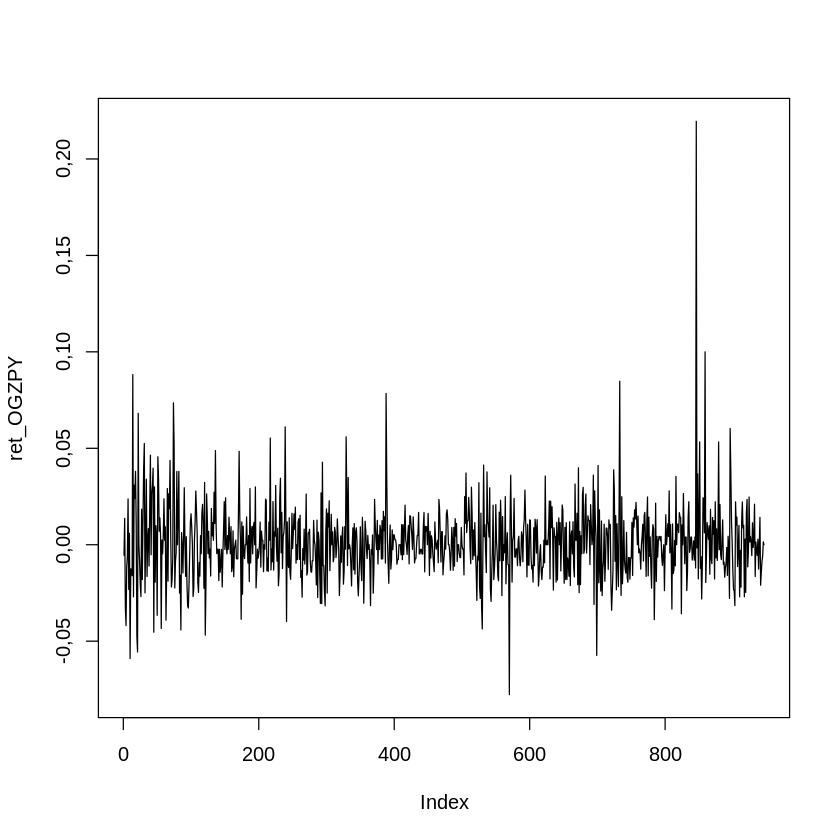

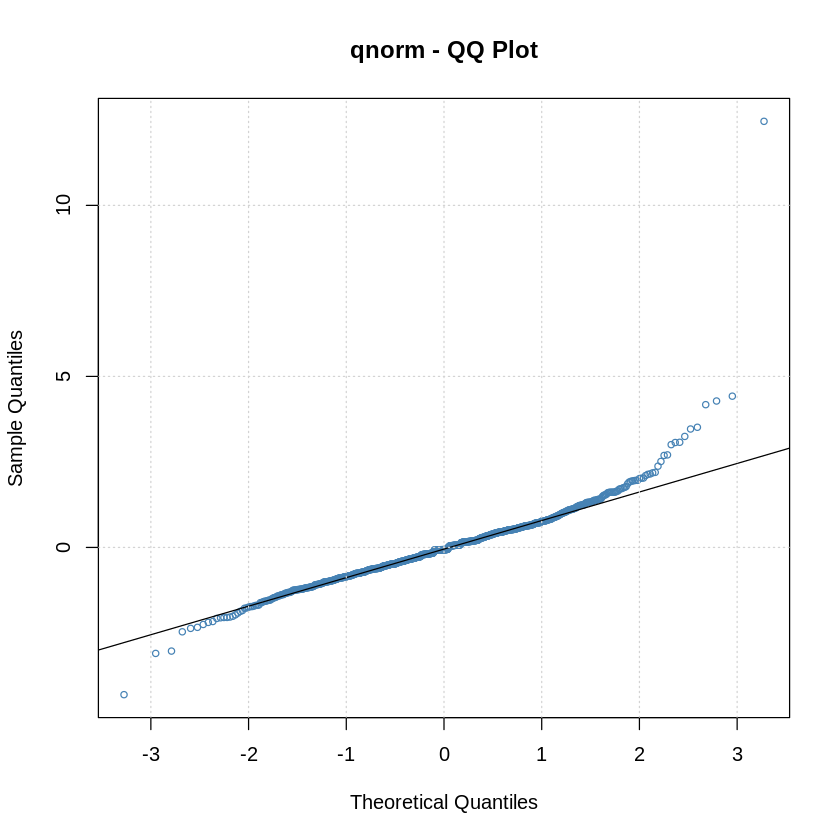

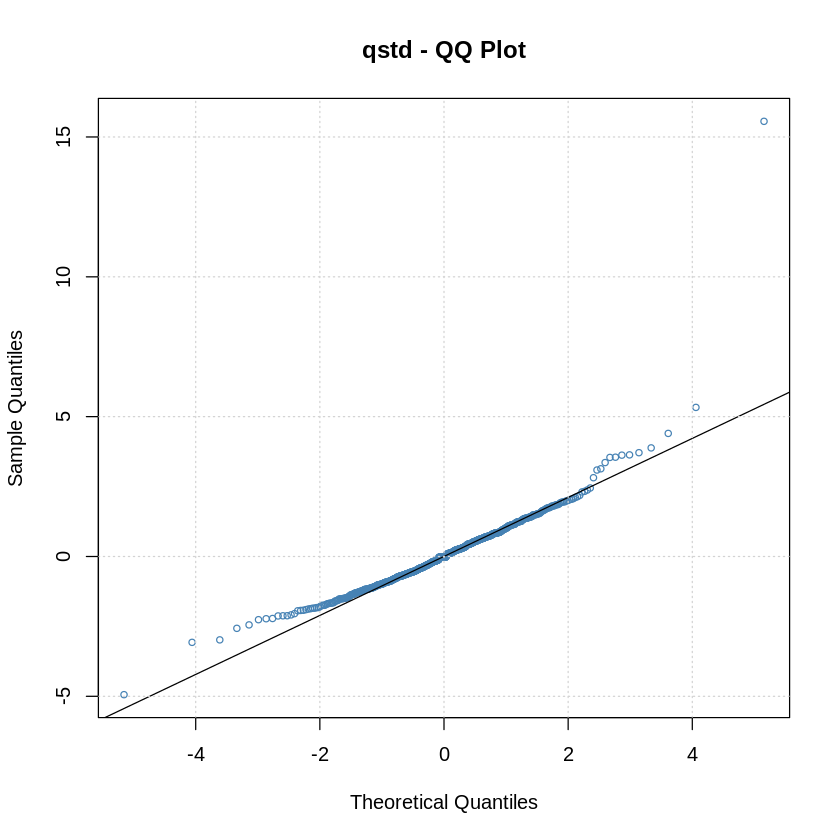

In [34]:
####################################### GAZPROM
data <- read.csv("/home/alex/Education/6/CMF/time_series/4/data/OGZPY.csv", header=TRUE, sep=",")
head(data)
prices_OGZPY = data[,"Adj.Close"]
prices_OGZPY

T = length(prices_OGZPY) - 1
ret_OGZPY <- (prices_OGZPY[2:(T+1)] / prices_OGZPY[1:T]) - 1
plot(ret_OGZPY, type='l')

##############################################
####### Compare QQ Plot of Normal and Student distributions
##############################################
garch.norm <- garchFit(~1+garch(1,1),data=ret_OGZPY,trace=F)
plot(garch.norm, which=13)

garch.st <- garchFit(~1+garch(1,1),data=ret_OGZPY,trace=F, cond.dist="std")
plot(garch.st, which=13) 
# QQ Plot for Student is better


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error     t value Pr(>|t|)
mu      0,000981    0,000008    118,0011 0,000000
ar1     0,989568    0,003910    253,0650 0,000000
ma1    -1,000000    0,000020 -50833,2722 0,000000
omega   0,000019    0,000012      1,5993 0,109750
alpha1  0,082610    0,038758      2,1314 0,033055
beta1   0,861446    0,064935     13,2662 0,000000
shape   5,131978    0,739691      6,9380 0,000000

Robust Standard Errors:
        Estimate  Std. Error     t value Pr(>|t|)
mu      0,000981    0,000013  7,7634e+01  0,00000
ar1     0,989568    0,003676  2,6920e+02  0,00000
ma1    -1,000000    0,000020 -4,9792e+04  0,00000
omega   0,000019    0,000019  9,8041e-01  0,32688
alpha1  0,082610 

VaR Backtest Report
Model:				sGARCH-std
Backtest Length:	646
Data:				

alpha:				1%
Expected Exceed:	6,5
Actual VaR Exceed:	4
Actual %:			0,6%

Unconditional Coverage (Kupiec)
Null-Hypothesis:	Correct Exceedances
LR.uc Statistic:	1,095
LR.uc Critical:		3,841
LR.uc p-value:		0,295
Reject Null:		NO

Conditional Coverage (Christoffersen)
Null-Hypothesis:	Correct Exceedances and
					Independence of Failures
LR.cc Statistic:	1,145
LR.cc Critical:		5,991
LR.cc p-value:		0,564
Reject Null:		NO
[1] "ES"
[1] -0,06438315


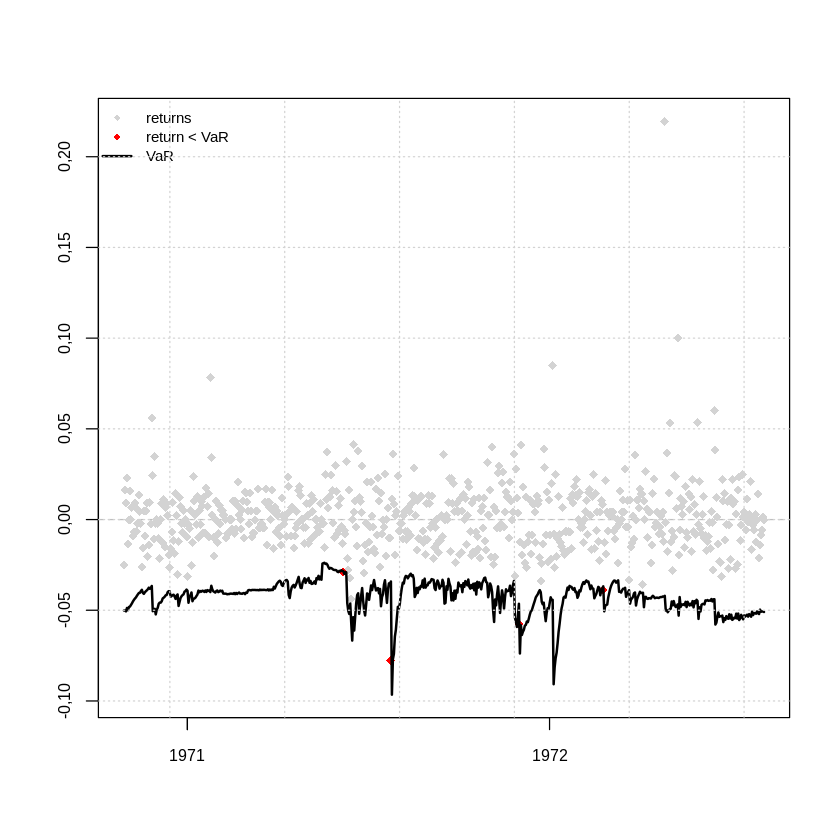

In [37]:
##############################################
####### Create ARIMA(1,0,1)-GARCH(1,1) model
####### n.ahead = 1, refit.every = 250
##############################################


model_OGZPY <- ugarchspec(variance.model = list(garchOrder = c(1,1)), mean.model = list(armaOrder = c(1,1), arfima=FALSE),distribution.model = "std")
model_OGZPY_fit <- ugarchfit(spec = model_F,data=ret_OGZPY)
model_OGZPY_fit

roll <- ugarchroll(model_OGZPY,ret_OGZPY,n.start = 300, refit.window = 'moving', moving.size = 250, calculate.VaR = TRUE, VaR.alpha = 0.01)
report(roll)
print("ES")
print(get_es(roll@forecast$VaR[,"alpha(1%)"]))
plot(roll, which=4) # "which=4" means print VaR

#Expected Exceed:	6.5
# Actual VaR Exceed:	4